In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [3]:
df = pd.read_excel("data/amazon.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


### Veri Önişleme


In [4]:
#Küçük Harflere Çevirme
df['Review'] = df['Review'].str.lower()

#Noktalama İşaretleri
df['Review'] = df['Review'].str.replace('[^\w\s]','', regex=True)

#Sayısal İfadeler
df['Review'] = df['Review'].str.replace('\d', '', regex=True)

In [6]:
#Stopwords Kaldırılması
import nltk
nltk.download('stopwords')

sw = stopwords.words('english')

df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bkork\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
#Rarewords Kaldırılması
rw = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]

df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in rw))

In [14]:
#Lemmatization İşlemi
nltk.download('wordnet')

df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bkork\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Veri Görselleştirme


In [16]:
#Term Frequency Hesaplama
tf = df['Review'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns = ["words", "tf"]

tf.sort_values("tf", ascending=False)

,words,tf
66,curtain,2588.0
42,look,1531.0
120,love,1453.0
104,room,1129.0
166,like,1053.0
...,...,...
2876,unwuiness,1.0
2878,enters,1.0
2879,soonbrlittle,1.0
2880,isbrbrlove,1.0


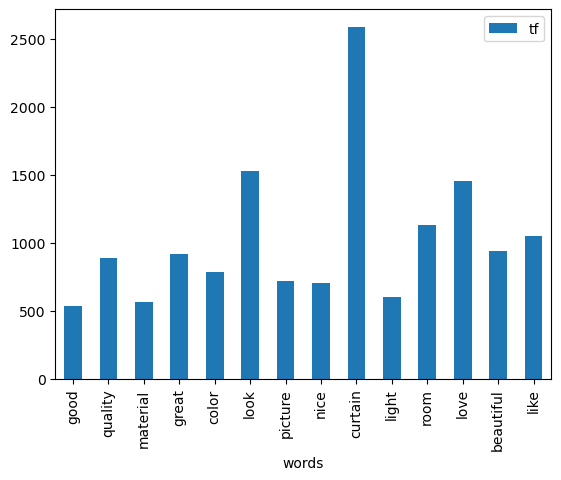

In [17]:
#Barplot
tf[tf["tf"] > 500].plot.bar(x='words', y='tf')

plt.show()

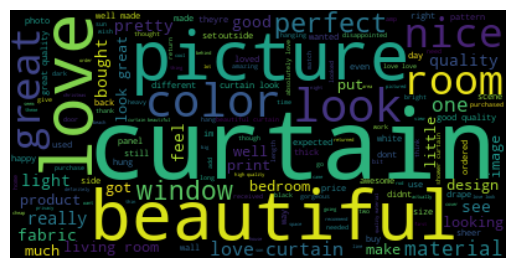

In [18]:
#Wordcloud

text = " ".join(i for i in df.Review)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Duygu Analizi

In [26]:
#nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["SentimentLabel"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["SentimentLabel"] = LabelEncoder().fit_transform(df["SentimentLabel"])

### Makine Öğrenmesine Hazırlık

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
#Bağımlı Bağımsız Değişkenlerin Belirlenmesi
y = df["SentimentLabel"]
X = df["Review"]

#Verinin eğitim ve test olarak ayrılması
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

#TF-IDF Vektörünün oluşturulması
tf_idf_word_vectorizer = TfidfVectorizer().fit(X_train)

X_train_tf_idf_word = tf_idf_word_vectorizer.transform(X_train)
X_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test)

### Modelleme (Lojistik Regresyon)

In [36]:
from sklearn.metrics import classification_report

#Lojistik Regresyon Modeli 
log_model = LogisticRegression().fit(X_train_tf_idf_word, y_train)

y_pred = log_model.predict(X_test_tf_idf_word)

print(classification_report(y_test, y_pred))

print(cross_val_score(log_model, X_test_tf_idf_word, y_test, cv=5).mean())

              precision    recall  f1-score   support

           0       0.90      0.33      0.49       223
           1       0.89      0.99      0.94      1180

    accuracy                           0.89      1403
   macro avg       0.89      0.66      0.71      1403
weighted avg       0.89      0.89      0.87      1403

0.8546034570411795


In [35]:
#Rastegele Yorum ile Tahminleme
from sklearn.feature_extraction.text import CountVectorizer

random_review = pd.Series(df['Review'].sample(1).values)

yeni_yorum = CountVectorizer().fit(X_train).transform(random_review)

pred = log_model.predict(yeni_yorum)

print(f'Review: {random_review[0]} \n Prediction: {pred}')

Review: coolest curtain ever 
 Prediction: [1]


### Modelleme (Random Forest)

In [37]:
#Random Forest Modeli

rf_model = RandomForestClassifier().fit(X_train_tf_idf_word, y_train)

y_pred = rf_model.predict(X_test_tf_idf_word)

print(classification_report(y_test, y_pred))

print(cross_val_score(rf_model, X_test_tf_idf_word, y_test, cv=5).mean())

              precision    recall  f1-score   support

           0       0.79      0.57      0.66       223
           1       0.92      0.97      0.95      1180

    accuracy                           0.91      1403
   macro avg       0.86      0.77      0.81      1403
weighted avg       0.90      0.91      0.90      1403

0.8909532282663954
